In [1]:
%load_ext watermark
%watermark -a "Ernesto Carro" -u -d -v -p numpy,scipy,matplotlib,torch,sklearn 

Ernesto Carro 
last updated: 2019-02-08 

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
scipy 1.1.0
matplotlib 3.0.2
torch 1.0.0
sklearn 0.20.1


# Clasificación de galaxias

El objetivo de esta tarea es hacer una red neuronal que pueda diferenciar entre tres tipos de galaxia: espiral, irregular y elíptica. Se va a hacer por medio de una red convolucional (para disminuír el número de parámetros de la red.

El ejercicio está basado en el [tutorial](https://www.tensorflow.org/tutorials/layers) de tensorflow para capas en una red convolutiva.

Las fotos de estas galaxias las necesitan sacar del folder zip que se llame 'source' (basta con darle click derecho y luego descomprimir, en realidad.

Primero lo primero, cargar las bibliotecas necesarias. Recuerden, si una les aparece que no está instalada, basta con que utilicen el ambiente virtual para instalar cosas. En particular, tensorflow y PIL (cuyo paquete se llama Pillow, es decir, `pip install pillow`).

In [2]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image
import os
import zipfile
import io
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import TensorDataset, DataLoader, Dataset

Ahora vamos a cargar en RAM todas las fotos. Para ello primero cargamos los nombres y sus tipos (lo único que nos interesa). Me aprovecho de ello para de una vez guardar en un data frame sólo las columnas de interés. No sólo eso pero de una vez vamos a convertir las etiquetas en las tres posibilidades de galaxia que nos interesa clasificar: Elíptica ()

In [3]:
data = pd.read_csv('EFIGI_data.txt', sep=",")

Podemos ver aquí los primeros 5 renglones de este dataframe

In [4]:
data.head()

,PhotoName,HStage,Type,NType
0,PGC0009530,10,I,2
1,PGC0025524,-5,E,0
2,PGC0002149,-3,S,1
3,PGC0004363,-3,S,1
4,PGC0004540,6,S,1


Esperemos tener una distribución masomenos equitativa de cada galaxia. Usando `groupby` podremos verificar esto

In [5]:
data.groupby("Type").count()

,PhotoName,HStage,NType
Type,,,
E,200,200,200
I,200,200,200
S,200,200,200


Pues... Resulta que no. En fin, A la mejor el problema fue dar un rango tan grande a las espirales

In [6]:
data.groupby("HStage").count().Type

HStage
-6      14
-5     163
-4      23
-3      18
-2      14
-1       7
 0       6
 1      19
 2      14
 3      18
 4      14
 5       8
 6      31
 7      15
 8      27
 9       9
 10    156
 11     44
Name: Type, dtype: int64

Si pues, un poco más homogeneo... Tenemos aún que cargar 82MB de imágenes en RAM. Esto puede ser un grave problema.

In [7]:
images = []
def ProcImage(row):
    archive = zipfile.ZipFile('source.zip', 'r')
    img_data = archive.read(os.path.join('source',row.PhotoName+'.png'))
    bytes_io = io.BytesIO(img_data)
    return Image.open(bytes_io).convert('L')
images = data.apply(lambda row: ProcImage(row), axis = 1)
shape = [images[0].height, images[0].width]
# To normalized numpy array
images = np.array(
    list(map(lambda pic: np.reshape(np.array(pic), [1, pic.width * pic.height])[0] , images)), dtype = 'float32'
) / 255
images.shape

(600, 65025)

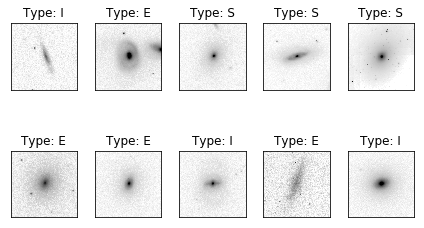

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5,
        sharex=True, sharey=True)
ax = ax.flatten()
to_selec = np.random.randint(600, size = 10)
for i in range(10):
    img = images[to_selec[i]].reshape(255, 255)
    ax[i].imshow(img, cmap='Greys')
    ax[i].set_title('Type: ' + data.iloc[i].Type)
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Dividimos los datos en tres partes,

In [9]:
train_data = data.iloc[:400].NType.values
train_images = images[:400]

test_data = data.iloc[400:500].NType.values
test_images = images[400:500]

validation_data = data.iloc[500:].NType.values
validation_images = images[500:]

Para poder comparar nuestra red neuronal, colocaremos como punto de referencia la precisión obtenida al usar el SVM clasificador de sckit-learn.

In [10]:
from sklearn import svm

def svm_baseline():
    clf = svm.SVC(gamma = 'auto')
    clf.fit(train_images, train_data)
    # test
    predictions = [int(a) for a in clf.predict(validation_images)]
    num_correct = sum(int(a == y) for a, y in zip(predictions, validation_data))
    print("Baseline classifier using an SVM.")
    print("%s of %s values correct." % (num_correct, len(validation_data)))
    
svm_baseline()

Baseline classifier using an SVM.
52 of 100 values correct.


Podemos ver que el SVM clasificador tiene una precisión del 52%, record que debemos de romper con nuestra red neuronal.

In [11]:
def vectorized_result(j):
    e = np.zeros(3)
    e[j] = 1.0
    return e

train_data = list(map(vectorized_result, train_data))
test_data = list(map(vectorized_result, test_data))
validation_data = list(map(vectorized_result, validation_data))

In [12]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Parameters
params = {'batch_size': 5,
          'shuffle': True,
          'num_workers': 1, 
          'pin_memory': True}

In [13]:
train_images, train_data = map(
    torch.tensor, (train_images, train_data)
)
train_ds = TensorDataset(train_images, train_data)
train_dl = DataLoader(train_ds, **params)

test_images, test_data = map(
    torch.tensor, (test_images, test_data)
)
test_ds = TensorDataset(test_images, test_data)
test_dl = DataLoader(test_ds, **params)

validation_images, validation_data = map(
    torch.tensor, (validation_images, validation_data)
)
validation_ds = TensorDataset(validation_images, validation_data)
validation_dl = DataLoader(validation_ds, **params)

Definimos nuestra red neuronal convolutiva.

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 6)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(3 * 125 * 125, 100)
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 3)

    def forward(self, x):
        x = x.view(-1, 1, 255, 255)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 3 * 125* 125)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

Estos son nuestros parámetros de red, usaremos como y la función de costo.

In [15]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = torch.max(target.long(), 1)[1]
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [16]:
def test(epoch, model, device, test_loader, best_accuracy, best_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            target = torch.max(target.long(), 1)[1]
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    if best_accuracy <= correct:
        best_accuracy = correct
        best_epoch = epoch
        print('This is the best test accuracy to date.')
    print('The corresonding test accuracy : {}/{}'.format(correct, 
        len(test_loader.dataset)))
    
    return best_accuracy, best_epoch

In [17]:
def validation(model, device, validation_loader):
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            target = torch.max(target.long(), 1)[1]
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(validation_loader.dataset)
    print('The corresonding validation accuracy : {}/{}'.format(correct, 
        len(validation_loader.dataset)))
    return correct

In [18]:
def fit(model, params_net, epochs, schedule = False):
    optimizer = optim.SGD(model.parameters(), **params_net)
    best_accuracy = 0
    best_epoch = 0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                        'max', verbose = True, patience = 20) 
    for epoch in range(1, epochs + 1):
        train(50, model, device, train_dl, optimizer, epoch)
        best_accuracy, best_epoch = test(epoch, model, device, 
                                         test_dl, best_accuracy, best_epoch)
        correct = validation(model,  device, validation_dl)
        
        if schedule:
            scheduler.step(correct)
        
        print('\n')
        
    print("Finished training network.")
    print("Corresponding test accuracy of {}/{} obtained in epoch {}".format(best_accuracy, 
                                                            len(test_dl.dataset), best_epoch))

In [19]:
params_net = {'lr':0.01, 'momentum':0.1}
fit(Net().to(device), params_net, 50)

Train Epoch: 1 [0/400 (0%)]	Loss: -0.319880
Train Epoch: 1 [250/400 (62%)]	Loss: -0.322103
This is the best test accuracy to date.
The corresonding test accuracy : 42/100
The corresonding validation accuracy : 25/100


Train Epoch: 2 [0/400 (0%)]	Loss: -0.368154
Train Epoch: 2 [250/400 (62%)]	Loss: -0.294899
This is the best test accuracy to date.
The corresonding test accuracy : 42/100
The corresonding validation accuracy : 25/100


Train Epoch: 3 [0/400 (0%)]	Loss: -0.364805
Train Epoch: 3 [250/400 (62%)]	Loss: -0.443519
This is the best test accuracy to date.
The corresonding test accuracy : 64/100
The corresonding validation accuracy : 53/100


Train Epoch: 4 [0/400 (0%)]	Loss: -0.363379
Train Epoch: 4 [250/400 (62%)]	Loss: -0.650076
The corresonding test accuracy : 58/100
The corresonding validation accuracy : 51/100


Train Epoch: 5 [0/400 (0%)]	Loss: -0.585795
Train Epoch: 5 [250/400 (62%)]	Loss: -0.632210
The corresonding test accuracy : 57/100
The corresonding validation accur

Train Epoch: 45 [250/400 (62%)]	Loss: -0.800646
The corresonding test accuracy : 75/100
The corresonding validation accuracy : 75/100


Train Epoch: 46 [0/400 (0%)]	Loss: -0.999997
Train Epoch: 46 [250/400 (62%)]	Loss: -0.770676
The corresonding test accuracy : 73/100
The corresonding validation accuracy : 75/100


Train Epoch: 47 [0/400 (0%)]	Loss: -0.993784
Train Epoch: 47 [250/400 (62%)]	Loss: -0.999740
The corresonding test accuracy : 72/100
The corresonding validation accuracy : 79/100


Train Epoch: 48 [0/400 (0%)]	Loss: -0.799991
Train Epoch: 48 [250/400 (62%)]	Loss: -0.799996
The corresonding test accuracy : 75/100
The corresonding validation accuracy : 69/100


Train Epoch: 49 [0/400 (0%)]	Loss: -0.786548
Train Epoch: 49 [250/400 (62%)]	Loss: -0.881060
The corresonding test accuracy : 76/100
The corresonding validation accuracy : 75/100


Train Epoch: 50 [0/400 (0%)]	Loss: -0.806285
Train Epoch: 50 [250/400 (62%)]	Loss: -0.762532
The corresonding test accuracy : 73/100
The cor

La mejor precisión fue del 80% sobre el conjunto de prueba. Ahora usaremos un algoritmo de actualización de la razón de aprendizaje para mejorar nuestra red.

In [20]:
# params_net = {'lr':0.01, 'momentum':0.1}
# fit(Net().to(device), params_net, schedule= schudle = True)

Usemos una red convolutiva más...

In [21]:
class Net_new(nn.Module):
    def __init__(self):
        super(Net_new, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 6, 6)
        self.fc1 = nn.Linear(6 * 60 * 60, 100)
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 3)

    def forward(self, x):
        x = x.view(-1, 1, 255, 255)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 60* 60)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [22]:
params_net = {'lr':0.01, 'momentum':0.1}
fit(Net_new().to(device), params_net, 50)

Train Epoch: 1 [0/400 (0%)]	Loss: -0.354223
Train Epoch: 1 [250/400 (62%)]	Loss: -0.336598
This is the best test accuracy to date.
The corresonding test accuracy : 33/100
The corresonding validation accuracy : 37/100


Train Epoch: 2 [0/400 (0%)]	Loss: -0.326194
Train Epoch: 2 [250/400 (62%)]	Loss: -0.352303
This is the best test accuracy to date.
The corresonding test accuracy : 33/100
The corresonding validation accuracy : 37/100


Train Epoch: 3 [0/400 (0%)]	Loss: -0.331774
Train Epoch: 3 [250/400 (62%)]	Loss: -0.327006
This is the best test accuracy to date.
The corresonding test accuracy : 33/100
The corresonding validation accuracy : 37/100


Train Epoch: 4 [0/400 (0%)]	Loss: -0.357427
Train Epoch: 4 [250/400 (62%)]	Loss: -0.341776
This is the best test accuracy to date.
The corresonding test accuracy : 33/100
The corresonding validation accuracy : 37/100


Train Epoch: 5 [0/400 (0%)]	Loss: -0.301996
Train Epoch: 5 [250/400 (62%)]	Loss: -0.324268
This is the best test accuracy to

The corresonding test accuracy : 73/100
The corresonding validation accuracy : 75/100


Train Epoch: 44 [0/400 (0%)]	Loss: -0.784496
Train Epoch: 44 [250/400 (62%)]	Loss: -0.599917
The corresonding test accuracy : 68/100
The corresonding validation accuracy : 75/100


Train Epoch: 45 [0/400 (0%)]	Loss: -0.799995
Train Epoch: 45 [250/400 (62%)]	Loss: -0.801951
The corresonding test accuracy : 67/100
The corresonding validation accuracy : 74/100


Train Epoch: 46 [0/400 (0%)]	Loss: -0.796961
Train Epoch: 46 [250/400 (62%)]	Loss: -0.800952
This is the best test accuracy to date.
The corresonding test accuracy : 79/100
The corresonding validation accuracy : 74/100


Train Epoch: 47 [0/400 (0%)]	Loss: -0.800001
Train Epoch: 47 [250/400 (62%)]	Loss: -0.799757
The corresonding test accuracy : 73/100
The corresonding validation accuracy : 72/100


Train Epoch: 48 [0/400 (0%)]	Loss: -0.600000
Train Epoch: 48 [250/400 (62%)]	Loss: -0.399905
The corresonding test accuracy : 68/100
The corresondin

No cambia realmente, ahora con el learning rate schudele...

In [23]:
# params_net = {'lr':0.01, 'momentum':0.1}
# fit(Net_new().to(device), params_net, 100, schedule = True)

La cosa no va muy bien, pero probemos a aumentar el conjunto de datos

In [33]:
def ProcImageRGB(row):
    archive = zipfile.ZipFile('source.zip', 'r')
    img_data = archive.read(os.path.join('source',row+'.png'))
    bytes_io = io.BytesIO(img_data)
    return Image.open(bytes_io).convert('RGB')

class CustomDatasetFromImages(Dataset):
    def __init__(self, data, transform_me=None):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.transform = transform_me
        self.data_info = data
        self.image_arr = np.asarray(self.data_info.PhotoName)
        self.label_arr = np.asarray(self.data_info.NType)
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        single_image_name = self.image_arr[index]
        img_as_img = ProcImageRGB(single_image_name)
    
        if self.transform is not None:
            img_as_tensor = self.transform(img_as_img)

        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

In [34]:
# Parameters
params = {'batch_size': 10,
          'shuffle': True,
          'num_workers': 1, 
          'pin_memory': True}

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched[0], sample_batched[1]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')

In [36]:
transform_me1 = transforms.Compose([
    transforms.Resize(255),
    transforms.ToTensor()
])
transform_me2 = transforms.Compose([
    transforms.Resize(255),
    transforms.RandomResizedCrop(255),
    transforms.ToTensor()
])
transform_me3 = transforms.Compose([
    transforms.Resize(255),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

train_dataset = (CustomDatasetFromImages(data.iloc[:400], transform_me1)
                + CustomDatasetFromImages(data.iloc[:400], transform_me2)
                + CustomDatasetFromImages(data.iloc[:400], transform_me3))
validation_dataset = (CustomDatasetFromImages(data.iloc[400:500], transform_me1)
                 + CustomDatasetFromImages(data.iloc[400:500], transform_me2)
                 + CustomDatasetFromImages(data.iloc[400:500], transform_me3))
test_dataset = (CustomDatasetFromImages(data.iloc[500:], transform_me1)
                 + CustomDatasetFromImages(data.iloc[500:], transform_me2)
                 + CustomDatasetFromImages(data.iloc[500:], transform_me3))

In [37]:
train_dl = DataLoader(train_dataset, **params)
validation_dl = DataLoader(validation_dataset, **params)
test_dl = DataLoader(test_dataset, **params)

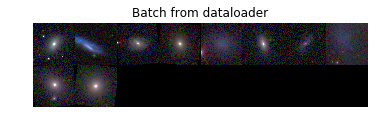

In [38]:
for i_batch, sample_batched in enumerate(train_dl):
    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

De esat forma hemos aumentado nuestro dataset y probaremos con una nueva red...

In [40]:
class Net_end(nn.Module):
    def __init__(self):
        super(Net_end, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 6)
        self.fc1 = nn.Linear(16 * 60 * 60, 100)
        self.fc2 = nn.Linear(100, 60)
        self.fc3 = nn.Linear(60, 3)

    def forward(self, x):
        x = x.view(-1, 3, 255, 255)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 60 * 60)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [41]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(epoch, model, device, test_loader, best_accuracy, best_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    if best_accuracy <= correct:
        best_accuracy = correct
        best_epoch = epoch
        print('This is the best test accuracy to date.')
    print('The corresonding test accuracy : {}/{}'.format(correct, 
        len(test_loader.dataset)))
    
    return best_accuracy, best_epoch

def validation(model, device, validation_loader):
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(validation_loader.dataset)
    print('The corresonding validation accuracy : {}/{}'.format(correct, 
        len(validation_loader.dataset)))
    return correct

def fit(model, params_net, epochs, schedule = False):
    optimizer = optim.SGD(model.parameters(), **params_net)
    best_accuracy = 0
    best_epoch = 0
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    for epoch in range(1, epochs + 1):
        if schedule:
            scheduler.step()
        train(50, model, device, train_dl, optimizer, epoch)
        best_accuracy, best_epoch = test(epoch, model, device, 
                                         test_dl, best_accuracy, best_epoch)
        correct = validation(model,  device, validation_dl)
        
        print('\n')
        
    print("Finished training network.")
    print("Corresponding test accuracy of {}/{} obtained in epoch {}".format(best_accuracy, 
                                                            len(test_dl.dataset), best_epoch))

In [42]:
params_net = {'lr':0.01, 'momentum':0.1}
fit(Net_end().to(device), params_net, 100, schedule = True)

Train Epoch: 1 [0/1200 (0%)]	Loss: -0.332593
Train Epoch: 1 [500/1200 (42%)]	Loss: -0.336492
Train Epoch: 1 [1000/1200 (83%)]	Loss: -0.325661
This is the best test accuracy to date.
The corresonding test accuracy : 114/300
The corresonding validation accuracy : 75/300


Train Epoch: 2 [0/1200 (0%)]	Loss: -0.334262
Train Epoch: 2 [500/1200 (42%)]	Loss: -0.342287
Train Epoch: 2 [1000/1200 (83%)]	Loss: -0.332893
The corresonding test accuracy : 99/300
The corresonding validation accuracy : 141/300


Train Epoch: 3 [0/1200 (0%)]	Loss: -0.330066
Train Epoch: 3 [500/1200 (42%)]	Loss: -0.395820
Train Epoch: 3 [1000/1200 (83%)]	Loss: -0.391333
The corresonding test accuracy : 103/300
The corresonding validation accuracy : 141/300


Train Epoch: 4 [0/1200 (0%)]	Loss: -0.464358
Train Epoch: 4 [500/1200 (42%)]	Loss: -0.495028
Train Epoch: 4 [1000/1200 (83%)]	Loss: -0.667880
This is the best test accuracy to date.
The corresonding test accuracy : 169/300
The corresonding validation accuracy : 162/

Train Epoch: 35 [1000/1200 (83%)]	Loss: -0.699388
The corresonding test accuracy : 205/300
The corresonding validation accuracy : 215/300


Train Epoch: 36 [0/1200 (0%)]	Loss: -0.883650
Train Epoch: 36 [500/1200 (42%)]	Loss: -0.780853
Train Epoch: 36 [1000/1200 (83%)]	Loss: -0.897413
The corresonding test accuracy : 208/300
The corresonding validation accuracy : 220/300


Train Epoch: 37 [0/1200 (0%)]	Loss: -0.658916
Train Epoch: 37 [500/1200 (42%)]	Loss: -0.813153
Train Epoch: 37 [1000/1200 (83%)]	Loss: -0.698668
The corresonding test accuracy : 211/300
The corresonding validation accuracy : 216/300


Train Epoch: 38 [0/1200 (0%)]	Loss: -0.773313
Train Epoch: 38 [500/1200 (42%)]	Loss: -0.898576
Train Epoch: 38 [1000/1200 (83%)]	Loss: -0.675602
The corresonding test accuracy : 209/300
The corresonding validation accuracy : 217/300


Train Epoch: 39 [0/1200 (0%)]	Loss: -0.896623
Train Epoch: 39 [500/1200 (42%)]	Loss: -0.899989
Train Epoch: 39 [1000/1200 (83%)]	Loss: -0.768273
The corres

KeyboardInterrupt: 